<a href="https://colab.research.google.com/github/WoojinJeonkr/DeepLearning/blob/main/Estimation_of_undocumented_SARS_CoV2_cases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 문서화되지 않은 SARS-CoV2 케이스의 예상치 분석
- 내용 출처: [Substantial Undocumented Infection Facilitates the Rapid Dissemination of Novel Coronavirus (SARS-CoV2)](https://www.tensorflow.org/probability/examples/Undocumented_Infection_and_the_Dissemination_of_SARS-CoV2)
- 목표: 문서화되지 않은 사례가 더 경미하여 문서화되지 않고 더 낮은 비율로 다른 사람들을 감염시킨다고 가정하고   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;원본 문서에서 주요 관심 매개변수는 문서화되지 않은 사례의 비율로,    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;기존 감염의 정도와 문서화되지 않은 전파가 질병의 확산에 미치는 영향을 모두 추정

## 01. 설치

In [1]:
!pip3 install -q tf-nightly tfp-nightly

     |████████████████████████████████| 582.7 MB 15 kB/s 
     |████████████████████████████████| 6.6 MB 39.0 MB/s 
     |████████████████████████████████| 439 kB 43.8 MB/s 
     |████████████████████████████████| 5.9 MB 29.6 MB/s 
     |████████████████████████████████| 1.7 MB 39.5 MB/s 


## 02. Import library

In [2]:
import collections
import io
import requests
import time
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
from tensorflow_probability.python.internal import samplers

tfd = tfp.distributions
tfes = tfp.experimental.sequential

## 03. 데이터 가져오기

In [3]:
r = requests.get('https://raw.githubusercontent.com/SenPei-CU/COVID-19/master/Data.zip')
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall('/tmp/')
raw_incidence = pd.read_csv('/tmp/data/Incidence.csv')
raw_mobility = pd.read_csv('/tmp/data/Mobility.csv')
raw_population = pd.read_csv('/tmp/data/pop.csv')

In [4]:
# 하루의 원시 발생 횟수 확인
raw_incidence.drop('Date', axis=1)

,Beijing,Tianjin,Shijiazhuang,Tangshan,Qinhuangdao,Handan,Xintai,Baoding,Zhangjiakou,Chengde,...,Tiemenguan,Shuanghe,Kekedala,Taiwan,Hongkong,Macao,Hetianxian (Xinjiang),Moyu,Yutian,Gejiu
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


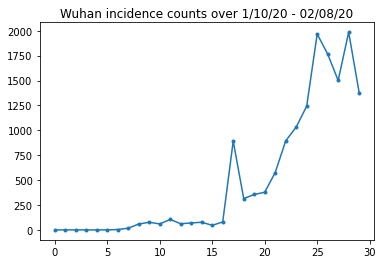

In [5]:
# 우한 발병 건수 건전성 확인
plt.plot(raw_incidence.Wuhan, '.-')
plt.title('Wuhan incidence counts over 1/10/20 - 02/08/20')
plt.show()

In [8]:
# 초기 인구
raw_population

,City,Population
0,Beijing,21540000.0
1,Tianjin,11760000.0
2,Shijiazhuang,10151200.0
3,Tangshan,7843600.0
4,Qinhuangdao,3094600.0
...,...,...
370,Macao,630000.0
371,Hetianxian (Xinjiang),360000.0
372,Moyu,646200.0
373,Yutian,289500.0


In [9]:
raw_population['City'][169]

'Wuhan'

In [10]:
WUHAN_IDX = 169

In [11]:
# 서로 다른 도시 간의 이동성 매트릭스
raw_mobility

,Day,Origin,Destination,Mobility Index
0,1,Beijing,Tianjin,17585
1,1,Beijing,Shijiazhuang,21289
2,1,Beijing,Handan,27676
3,1,Beijing,Baoding,19007
4,1,Beijing,Zhangjiakou,20327
...,...,...,...,...
92243,14,Gejiu,Lanzhou,60
92244,14,Gejiu,Pingliang,73
92245,14,Gejiu,Dongxi,126
92246,14,Gejiu,Xining,31


In [12]:
# numpy 배열로 전처리
initial_population = raw_population['Population'].to_numpy().astype(np.float32)

In [13]:
# 이동성 데이터를 [L, L, T] 모양의 Tensor로 변환(L: 위치 수, T: 시간 단계 수)
daily_mobility_matrices = []
for i in range(1, 15):
  day_mobility = raw_mobility[raw_mobility['Day'] == i]

  # 메트릭스 생성
  z = pd.crosstab(
      day_mobility.Origin, 
      day_mobility.Destination, 
      values=day_mobility['Mobility Index'], aggfunc='sum', dropna=False)

  z = z.reindex(index=raw_population['City'], columns=raw_population['City'], 
                fill_value=0)
  z = z.fillna(0)
  daily_mobility_matrices.append(z.to_numpy())

mobility_matrix_over_time = np.stack(daily_mobility_matrices, axis=-1).astype(
    np.float32)

In [14]:
# 관찰된 감염을 [L, T] 테이블로 생성
observed_daily_infectious_count = raw_incidence.to_numpy()[:14, 1:]
observed_daily_infectious_count = np.transpose(
    observed_daily_infectious_count).astype(np.float32)

In [15]:
# 원하는 모양을 얻었는지 확인
print('Mobility Matrix over time should have shape (375, 375, 14): {}'.format(
    mobility_matrix_over_time.shape))
print('Observed Infectious should have shape (375, 14): {}'.format(
    observed_daily_infectious_count.shape))
print('Initial population should have shape (375): {}'.format(
    initial_population.shape))

Mobility Matrix over time should have shape (375, 375, 14): (375, 375, 14)
Observed Infectious should have shape (375, 14): (375, 14)
Initial population should have shape (375): (375,)


## 04. 상태 및 매개변수 정의
- 재현 모델은 SEIR 모델에서 변화된 모델
1. S: 도시에서 질병에 민감한 사람들의 수.
2. E: 질병에 노출 각 도시에있는 사람들의 수
3. Iu : 전염성하지만 문서화되어 각 도시에있는 사람들의 수
4. Ir : 감염과 같은 문서화되어 각 도시에 있는 사람들의 수
- 추론 가능한 전역 시불변 매개변수
1. β: 문서화 된 감염성 개인에 대한 전송 속도
2. μ: 문서화되지 않은 감염성 개인 상대 전송 속도
3. θ: 도시 간 이동성 요소. 이동성 데이터의 과소 보고(2018년부터 2020년까지의 인구 증가)를 수정하는 데 1보다 큰 요소
4. Ζ: 평균 잠복기
5. α:심각한 감염의 비율
6. D: 감염의 평균 지속 시간
- 추론되지 않은 상수
1. M: 도시 간 이동 행렬, 시간에 따라 달라지며 주어진 것으로 추정
2. N: 각 도시에있는 사람의 총 수, 인구의 시간 변화는 이동성 번호에서 계산

In [16]:
# 상태와 매개변수를 유지하기 위한 데이터 구조
SEIRComponents = collections.namedtuple(
  typename='SEIRComponents',
  field_names=[
    'susceptible',
    'exposed',
    'documented_infectious',
    'undocumented_infectious',
    'daily_new_documented_infectious'])

ModelParams = collections.namedtuple(
    typename='ModelParams',
    field_names=[
      'documented_infectious_tx_rate',
      'undocumented_infectious_tx_relative_rate',
      'intercity_underreporting_factor',
      'average_latency_period',
      'fraction_of_documented_infections',
      'average_infection_duration'
    ]
)

In [17]:
# 매개변수 값에 대한 Li et al의 경계
PARAMETER_LOWER_BOUNDS = ModelParams(
    documented_infectious_tx_rate=0.8,
    undocumented_infectious_tx_relative_rate=0.2,
    intercity_underreporting_factor=1.,
    average_latency_period=2.,
    fraction_of_documented_infections=0.02,
    average_infection_duration=2.
)

PARAMETER_UPPER_BOUNDS = ModelParams(
    documented_infectious_tx_rate=1.5,
    undocumented_infectious_tx_relative_rate=1.,
    intercity_underreporting_factor=1.75,
    average_latency_period=5.,
    fraction_of_documented_infections=1.,
    average_infection_duration=5.
)

## 05. SEIR 역학

In [18]:
# 푸아송 노이즈 계산 함수 정의
def sample_state_deltas(
    state, population, mobility_matrix, params, seed, is_deterministic=False):
  undocumented_infectious_fraction = state.undocumented_infectious / population
  documented_infectious_fraction = state.documented_infectious / population

  mobile_population = (population - state.documented_infectious)
  def compute_outflow(compartment_population):
    raw_mobility = tf.linalg.matvec(
        mobility_matrix, compartment_population / mobile_population)
    return params.intercity_underreporting_factor * raw_mobility
  def compute_inflow(compartment_population):
    raw_mobility = tf.linalg.matmul(
        mobility_matrix,
        (compartment_population / mobile_population)[..., tf.newaxis],
        transpose_a=True)
    return params.intercity_underreporting_factor * tf.squeeze(
        raw_mobility, axis=-1)

  seeds = samplers.split_seed(seed, n=11)
  if is_deterministic:
    def sample_poisson(rate):
      return rate
  else:
    def sample_poisson(rate):
      return tfd.Poisson(rate=rate).sample(seed=seeds.pop())

  susceptible_becoming_exposed = sample_poisson(
      state.susceptible *
      (params.documented_infectious_tx_rate *
       documented_infectious_fraction +
       (params.undocumented_infectious_tx_relative_rate *
        params.documented_infectious_tx_rate) *
       undocumented_infectious_fraction))  # U1 + U2

  susceptible_population_inflow = sample_poisson(
      compute_inflow(state.susceptible))  # U3
  susceptible_population_outflow = sample_poisson(
      compute_outflow(state.susceptible))  # U4

  exposed_becoming_documented_infectious = sample_poisson(
      params.fraction_of_documented_infections *
      state.exposed / params.average_latency_period)  # U5
  exposed_becoming_undocumented_infectious = sample_poisson(
      (1 - params.fraction_of_documented_infections) *
      state.exposed / params.average_latency_period)  # U6

  exposed_population_inflow = sample_poisson(
      compute_inflow(state.exposed))  # U7
  exposed_population_outflow = sample_poisson(
      compute_outflow(state.exposed))  # U8

  documented_infectious_becoming_recovered = sample_poisson(
      state.documented_infectious /
      params.average_infection_duration)  # U9
  undocumented_infectious_becoming_recovered = sample_poisson(
      state.undocumented_infectious /
      params.average_infection_duration)  # U10

  undocumented_infectious_population_inflow = sample_poisson(
      compute_inflow(state.undocumented_infectious))  # U11
  undocumented_infectious_population_outflow = sample_poisson(
      compute_outflow(state.undocumented_infectious))  # U12

  return SEIRComponents(
      susceptible=(-susceptible_becoming_exposed +
                   susceptible_population_inflow +
                   -susceptible_population_outflow),
      exposed=(susceptible_becoming_exposed +
               -exposed_becoming_documented_infectious +
               -exposed_becoming_undocumented_infectious +
               exposed_population_inflow +
               -exposed_population_outflow),
      documented_infectious=(
          exposed_becoming_documented_infectious +
          -documented_infectious_becoming_recovered),
      undocumented_infectious=(
          exposed_becoming_undocumented_infectious +
          -undocumented_infectious_becoming_recovered +
          undocumented_infectious_population_inflow +
          -undocumented_infectious_population_outflow),
      daily_new_documented_infectious=exposed_becoming_documented_infectious)

In [19]:
@tf.function(autograph=False)
def rk4_one_step(state, population, mobility_matrix, params, seed):
  seeds = samplers.split_seed(seed, n=4)

  deltas = tf.nest.map_structure(tf.zeros_like, state)
  combined_deltas = tf.nest.map_structure(tf.zeros_like, state)

  for a, b in zip([1., 2, 2, 1.], [6., 3., 3., 6.]):
    next_input = tf.nest.map_structure(
        lambda x, delta, a=a: x + delta / a, state, deltas)
    deltas = sample_state_deltas(
        next_input,
        population,
        mobility_matrix,
        params,
        seed=seeds.pop(), is_deterministic=False)
    combined_deltas = tf.nest.map_structure(
        lambda x, delta, b=b: x + delta / b, combined_deltas, deltas)

  return tf.nest.map_structure(
      lambda s, delta: s + tf.round(delta),
      state, combined_deltas)

## 06. 초기화 체계 구현
- 내부 EAKF의 초기 상태
- 첫 번째 EAKF의 초기 매개변수이기도 한 외부 IF의 초기 매개변수
- 첫 번째가 아닌 각 EAKF에 대한 초기 매개변수 역할을 하는 한 IF 반복에서 다음 반복으로 매개변수 업데이트

In [20]:
def initialize_state(num_particles, num_batches, seed):
  num_cities = mobility_matrix_over_time.shape[-2]
  state_shape = [num_particles, num_batches, num_cities]
  susceptible = initial_population * np.ones(state_shape, dtype=np.float32)
  documented_infectious = np.zeros(state_shape, dtype=np.float32)
  daily_new_documented_infectious = np.zeros(state_shape, dtype=np.float32)

  rng = np.random.RandomState(seed[0] % (2**31 - 1))
  wuhan_exposed = rng.randint(
      0, 2001, [num_particles, num_batches]).astype(np.float32)
  wuhan_undocumented_infectious = rng.randint(
      0, 2001, [num_particles, num_batches]).astype(np.float32)

  exposed = 3 * mobility_matrix_over_time[
      WUHAN_IDX, :, 0] * wuhan_exposed[
          ..., np.newaxis] / initial_population[WUHAN_IDX]
  undocumented_infectious = 3 * mobility_matrix_over_time[
      WUHAN_IDX, :, 0] * wuhan_undocumented_infectious[
          ..., np.newaxis] / initial_population[WUHAN_IDX]

  exposed[..., WUHAN_IDX] = wuhan_exposed
  undocumented_infectious[..., WUHAN_IDX] = wuhan_undocumented_infectious

  return SEIRComponents(
      susceptible=tf.constant(susceptible),
      exposed=tf.constant(exposed),
      documented_infectious=tf.constant(documented_infectious),
      undocumented_infectious=tf.constant(undocumented_infectious),
      daily_new_documented_infectious=tf.constant(daily_new_documented_infectious))

def initialize_params(num_particles, num_batches, seed):
  halton_sequence = tfp.mcmc.sample_halton_sequence(
      dim=6, num_results=num_particles * num_batches, seed=seed)
  halton_sequence = tf.reshape(
      halton_sequence, [num_particles, num_batches, 6])
  halton_sequences = tf.nest.pack_sequence_as(
      PARAMETER_LOWER_BOUNDS, tf.split(
          halton_sequence, num_or_size_splits=6, axis=-1))
  def interpolate(minval, maxval, h):
    return (maxval - minval) * h + minval
  return tf.nest.map_structure(
      interpolate,
      PARAMETER_LOWER_BOUNDS, PARAMETER_UPPER_BOUNDS, halton_sequences)

def update_params(num_particles, num_batches,
                  prev_params, parameter_variance, seed):
  seeds = tf.nest.pack_sequence_as(
      prev_params, samplers.split_seed(seed, n=len(prev_params)))
  return tf.nest.map_structure(
      lambda x, v, seed: x + tf.math.sqrt(v) * tf.random.stateless_normal([
          num_particles, num_batches, 1], seed=seed),
      prev_params, parameter_variance, seeds)

## 07. 지연

In [21]:
def raw_reporting_delay_distribution(gamma_shape=1.85, reporting_delay=9.):
  return tfp.distributions.Gamma(
      concentration=gamma_shape, rate=gamma_shape / reporting_delay)

In [22]:
def reporting_delay_probs(num_timesteps, gamma_shape=1.85, reporting_delay=9.):
  gamma_dist = raw_reporting_delay_distribution(gamma_shape, reporting_delay)
  multinomial_probs = [gamma_dist.cdf(1.)]
  for k in range(2, num_timesteps + 1):
    multinomial_probs.append(gamma_dist.cdf(k) - gamma_dist.cdf(k - 1))
  multinomial_probs.append(gamma_dist.survival_function(num_timesteps))
  multinomial_probs = tf.stack(multinomial_probs)
  return multinomial_probs

In [23]:
# 새로운 일일 문서화 감염 수에 지연을 실제로 적용
def delay_reporting(
    daily_new_documented_infectious, num_timesteps, t, multinomial_probs, seed):
  raw_delays = tfd.Multinomial(
      total_count=daily_new_documented_infectious,
      probs=multinomial_probs).sample(seed=seed)

  clipped_delays = raw_delays[..., :-1]

  clipped_delays = clipped_delays[..., :num_timesteps - t]
  return tf.concat([
      tf.zeros(
          tf.concat([
              tf.shape(clipped_delays)[:-1], [t]], axis=0),
          dtype=clipped_delays.dtype),
      clipped_delays], axis=-1)

## 08. 추론

In [24]:
# 모든 부가 정보를 모델에 패키징
ParameterStatePair = collections.namedtuple(
    'ParameterStatePair', ['state', 'params'])

SideInfo = collections.namedtuple(
    'SideInfo', [
        'observations_over_time',
        'initial_population',
        'mobility_matrix_over_time',
        'population',
        'actual_reported_cases',
        'multinomial_probs',
        'seed',
    ])

MINIMUM_CITY_FRACTION = 0.6
INFLATION_FACTOR = 1.1

INFLATE_FN = tfes.inflate_by_scaled_identity_fn(INFLATION_FACTOR)

In [25]:
# Ensemble Kalman Filter용으로 패키징된 완전한 관찰 모델
def observation_fn(t, state_params, extra):
  daily_new_documented_infectious = state_params.state.daily_new_documented_infectious[..., 0]
  observations_over_time = extra.observations_over_time
  num_timesteps = observations_over_time.shape[-1]

  seed, new_seed = samplers.split_seed(extra.seed, salt='reporting delay')

  daily_delayed_counts = delay_reporting(
      daily_new_documented_infectious, num_timesteps, t,
      extra.multinomial_probs, seed)
  observations_over_time = observations_over_time + daily_delayed_counts

  extra = extra._replace(
      observations_over_time=observations_over_time,
      seed=new_seed)

  adjusted_observations = observations_over_time[..., t][..., tf.newaxis]
  return tfd.MultivariateNormalDiag(
      loc=adjusted_observations,
      scale_diag=tf.math.maximum(
          2., extra.actual_reported_cases[..., t][..., tf.newaxis] / 2.)), extra

In [26]:
# 전환 역학 정의
# EAKF 프레임워크용으로 패키지화하고 Li et al에 따라 도시 인구가 너무 작아지는 것을 방지하기 위해 잘라냄
def transition_fn(t, state_params, extra):
  mobility_t = extra.mobility_matrix_over_time[..., t]
  new_seed, rk4_seed = samplers.split_seed(extra.seed, salt='Transition')
  new_state = rk4_one_step(
      state_params.state,
      extra.population,
      mobility_t,
      state_params.params,
      seed=rk4_seed)

  new_population = (
      extra.population + state_params.params.intercity_underreporting_factor * (
          tf.reduce_sum(mobility_t, axis=-2) - 
          tf.reduce_sum(mobility_t, axis=-1)))
  new_population = tf.where(
      new_population < MINIMUM_CITY_FRACTION * extra.initial_population,
      extra.initial_population * MINIMUM_CITY_FRACTION,
      new_population)

  extra = extra._replace(population=new_population, seed=new_seed)

  new_state = tfd.JointDistributionNamed(
      model=tf.nest.map_structure(lambda x: tfd.VectorDeterministic(x), new_state))
  params = tfd.JointDistributionNamed(
      model=tf.nest.map_structure(lambda x: tfd.VectorDeterministic(x), state_params.params))

  state_params = tfd.JointDistributionNamed(
      model=ParameterStatePair(state=new_state, params=params))

  return state_params, extra

In [27]:
# 추론 방법 정의
# 외부 루프: 반복 필터링, 내부 루프: 앙상블 조정 칼만 필터링
ensemble_kalman_filter_predict = tf.function(
    tfes.ensemble_kalman_filter_predict, autograph=False)
ensemble_adjustment_kalman_filter_update = tf.function(
    tfes.ensemble_adjustment_kalman_filter_update, autograph=False)

def inference(
    num_ensembles,
    num_batches,
    num_iterations,
    actual_reported_cases,
    mobility_matrix_over_time,
    seed=None,
    variance_shrinkage_factor=0.9,
    reporting_delay=9.,
    gamma_shape_parameter=1.85):

  print('Starting inference.')
  num_timesteps = actual_reported_cases.shape[-1]
  params_per_iter = []

  multinomial_probs = reporting_delay_probs(
      num_timesteps, gamma_shape_parameter, reporting_delay)

  seed = samplers.sanitize_seed(seed, salt='Inference')

  for i in range(num_iterations):
    start_if_time = time.time()
    seeds = samplers.split_seed(seed, n=4, salt='Initialize')
    if params_per_iter:
      parameter_variance = tf.nest.map_structure(
          lambda minval, maxval: variance_shrinkage_factor ** (
              2 * i) * (maxval - minval) ** 2 / 4.,
          PARAMETER_LOWER_BOUNDS, PARAMETER_UPPER_BOUNDS)
      params_t = update_params(
          num_ensembles,
          num_batches,
          prev_params=params_per_iter[-1],
          parameter_variance=parameter_variance,
          seed=seeds.pop())
    else:
      params_t = initialize_params(num_ensembles, num_batches, seed=seeds.pop())

    state_t = initialize_state(num_ensembles, num_batches, seed=seeds.pop())
    population_t = sum(x for x in state_t)
    observations_over_time = tf.zeros(
        [num_ensembles,
         num_batches,
         actual_reported_cases.shape[0], num_timesteps])

    extra = SideInfo(
        observations_over_time=observations_over_time,
        initial_population=tf.identity(population_t),
        mobility_matrix_over_time=mobility_matrix_over_time,
        population=population_t,
        multinomial_probs=multinomial_probs,
        actual_reported_cases=actual_reported_cases,
        seed=seeds.pop())

    state_t = clip_state(state_t, population_t)
    params_t = clip_params(params_t, seed=seeds.pop())

    params_over_time = tf.nest.map_structure(
        lambda x: tf.identity(x), params_t)

    state_params = ParameterStatePair(state=state_t, params=params_t)

    eakf_state = tfes.EnsembleKalmanFilterState(
        step=tf.constant(0), particles=state_params, extra=extra)

    for j in range(num_timesteps):
      seeds = samplers.split_seed(eakf_state.extra.seed, n=3)

      extra = extra._replace(seed=seeds.pop())

      new_particles = INFLATE_FN(eakf_state.particles)
      state_t = clip_state(new_particles.state, eakf_state.extra.population)
      params_t = clip_params(new_particles.params, seed=seeds.pop())
      eakf_state = eakf_state._replace(
          particles=ParameterStatePair(params=params_t, state=state_t))

      eakf_predict_state = ensemble_kalman_filter_predict(eakf_state, transition_fn)

      state_params = eakf_predict_state.particles
      state_t = clip_state(
          state_params.state, eakf_predict_state.extra.population)
      state_params = ParameterStatePair(state=state_t, params=state_params.params)

      state_params = tf.nest.map_structure(lambda x: x[..., tf.newaxis], state_params)
      eakf_predict_state = eakf_predict_state._replace(particles=state_params)

      # Update step.

      eakf_update_state = ensemble_adjustment_kalman_filter_update(
          eakf_predict_state,
          actual_reported_cases[..., j][..., tf.newaxis],
          observation_fn)

      state_params = tf.nest.map_structure(
          lambda x: x[..., 0], eakf_update_state.particles)

      state_t = clip_state(
          state_params.state, eakf_update_state.extra.population)
      params_t = tf.nest.map_structure(
          lambda x, y: x + tf.reduce_sum(y[..., tf.newaxis] - x, axis=-2, keepdims=True),
          eakf_predict_state.particles.params, state_params.params)
      params_t = clip_params(params_t, seed=seeds.pop())
      params_t = tf.nest.map_structure(lambda x: x[..., 0], params_t)

      state_params = ParameterStatePair(state=state_t, params=params_t)
      eakf_state = eakf_update_state
      eakf_state = eakf_state._replace(particles=state_params)

      params_over_time = tf.nest.map_structure(
          lambda s, x: tf.concat([s, x], axis=-1), params_over_time, params_t)

    est_params = tf.nest.map_structure(
        lambda x: tf.math.reduce_mean(x, axis=[0, -1])[..., tf.newaxis],
        params_over_time)
    params_per_iter.append(est_params)
    print('Iterated Filtering {} / {} Ran in: {:.2f} seconds'.format(
        i, num_iterations, time.time() - start_if_time))

  return tf.nest.map_structure(
      lambda x: tf.squeeze(x, axis=-1), params_per_iter[-1])

In [28]:
# 매개변수와 상태 클리핑
def clip_state(state, population):
  state = tf.nest.map_structure(
      lambda x: tf.where(x < 0, 0., x), state)

  susceptible = tf.where(state.susceptible > population, population, state.susceptible)
  return SEIRComponents(
      susceptible=susceptible,
      exposed=state.exposed,
      documented_infectious=state.documented_infectious,
      undocumented_infectious=state.undocumented_infectious,
      daily_new_documented_infectious=state.daily_new_documented_infectious)

def clip_params(params, seed):
  def _clip(p, minval, maxval):
    return tf.where(
        p < minval,
        minval * (1. + 0.1 * tf.random.stateless_uniform(p.shape, seed=seed)),
        tf.where(p > maxval,
                 maxval * (1. - 0.1 * tf.random.stateless_uniform(
                     p.shape, seed=seed)), p))
  params = tf.nest.map_structure(
      _clip, params, PARAMETER_LOWER_BOUNDS, PARAMETER_UPPER_BOUNDS)

  return params

## 09. 모델 실행

In [29]:
best_parameters = inference(
    num_ensembles=300,
    num_batches=30,
    num_iterations=10,
    actual_reported_cases=observed_daily_infectious_count,
    mobility_matrix_over_time=mobility_matrix_over_time)

Starting inference.
Iterated Filtering 0 / 10 Ran in: 286.68 seconds
Iterated Filtering 1 / 10 Ran in: 260.73 seconds
Iterated Filtering 2 / 10 Ran in: 259.83 seconds
Iterated Filtering 3 / 10 Ran in: 262.54 seconds
Iterated Filtering 4 / 10 Ran in: 260.33 seconds
Iterated Filtering 5 / 10 Ran in: 258.82 seconds
Iterated Filtering 6 / 10 Ran in: 259.21 seconds
Iterated Filtering 7 / 10 Ran in: 259.54 seconds
Iterated Filtering 8 / 10 Ran in: 259.65 seconds
Iterated Filtering 9 / 10 Ran in: 260.10 seconds


## 10. 결과 시각화

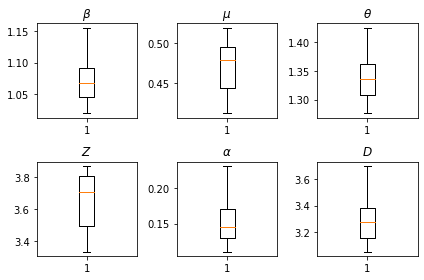

In [30]:
fig, axs = plt.subplots(2, 3)
axs[0, 0].boxplot(best_parameters.documented_infectious_tx_rate,
                  whis=(2.5,97.5), sym='')
axs[0, 0].set_title(r'$\beta$')

axs[0, 1].boxplot(best_parameters.undocumented_infectious_tx_relative_rate,
                  whis=(2.5,97.5), sym='')
axs[0, 1].set_title(r'$\mu$')

axs[0, 2].boxplot(best_parameters.intercity_underreporting_factor,
                  whis=(2.5,97.5), sym='')
axs[0, 2].set_title(r'$\theta$')

axs[1, 0].boxplot(best_parameters.average_latency_period,
                  whis=(2.5,97.5), sym='')
axs[1, 0].set_title(r'$Z$')

axs[1, 1].boxplot(best_parameters.fraction_of_documented_infections,
                  whis=(2.5,97.5), sym='')
axs[1, 1].set_title(r'$\alpha$')

axs[1, 2].boxplot(best_parameters.average_infection_duration,
                  whis=(2.5,97.5), sym='')
axs[1, 2].set_title(r'$D$')
plt.tight_layout()